In [27]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import time
from sklearn.metrics import f1_score, classification_report, precision_recall_fscore_support
import re
from IPython.display import display, clear_output

In [2]:
def preprocess_data(data_path):
    data = pd.read_csv(data_path)
    data['label'] = data['Suicide'].map({'suicide': 1, 'non-suicide': 0})
    data = data.dropna(subset=['Tweet', 'label'])
    # Enhanced preprocessing
    data['Tweet'] = data['Tweet'].str.lower()
    data['Tweet'] = data['Tweet'].str.replace(r'http\S+|www.\S+', '', regex=True)  # Remove URLs
    data['Tweet'] = data['Tweet'].str.replace(r'@\w+', '@user', regex=True)  # Standardize mentions
    data['Tweet'] = data['Tweet'].str.replace(r'[^\w\s]', '', regex=True)  # Remove special characters
    return data

In [3]:
# Dataset class with proper padding
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, tokenizer, MAX_LENGTH = 512):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.max_length = MAX_LENGTH
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        tokens = self.tokenizer(self.texts.iloc[idx])
        indices = [self.vocab[token] for token in tokens]

        # Padding/truncating
        if len(indices) < self.max_length:
            indices = indices + [self.vocab['<pad>']] * (self.max_length - len(indices))
        else:
            indices = indices[:self.max_length]

        return torch.tensor(indices, dtype=torch.long), torch.tensor(self.labels.iloc[idx], dtype=torch.long)

In [4]:
# Enhanced model with LSTM
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=2, dropout=0.5):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=1)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                           batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        hidden = self.dropout(hidden)
        return self.fc(hidden)

In [5]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
    val_f1 = f1_score(val_labels, val_preds, average='binary')
    val_report = classification_report(val_labels, val_preds, digits=4)
    return total_loss / len(dataloader), correct / total, val_f1, val_report

In [6]:
def train_model(model, train_dataloader, val_dataloader, criterion, optimizer,
                device, num_epochs=25, patience=3):
    best_val_loss = float('inf')
    patience_counter = 0
    train_acc_hist = []
    train_loss_hist = []
    val_loss_hist = []
    val_acc_hist = []
    train_f1_hist = []
    val_f1_hist = []
    for epoch in range(num_epochs):
        # Training
        start_time = time.time()
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        for texts, labels in train_dataloader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        train_loss = total_loss / len(train_dataloader)
        train_acc = correct / total
        train_f1 = f1_score(all_labels, all_preds, average='binary')
        train_report = classification_report(all_labels, all_preds, digits=4)
        # Validation
        val_loss, val_acc, val_f1, val_report = evaluate(model, val_dataloader, criterion, device)
        # Calculate time elapsed
        epoch_time = time.time() - start_time

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'Train F1: {train_f1}')
        print('Train classification Report:')
        print(train_report)
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
        print(f'Val F1: {val_f1}')
        print('Val classification Report:')
        print(val_report)
        print(f'Time Elapsed: {epoch_time:.2f} seconds')
        train_acc_hist.append(train_acc)
        train_loss_hist.append(train_loss)
        train_f1_hist.append(train_f1)
        val_acc_hist.append(val_acc)
        val_loss_hist.append(val_loss)
        val_f1_hist.append(val_f1)
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping triggered')
                return epoch, train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist, train_f1_hist, val_f1_hist
                break
    return epoch, train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist, train_f1_hist, val_f1_hist


In [7]:
EMBED_DIM = 256
HIDDEN_DIM = 128
BATCH_SIZE = 650
LEARNING_RATE = 1e-4
MAX_LENGTH = 512

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
data = preprocess_data('/kaggle/input/suicide-tweet/Suicide_Detection.csv')
data.head()

,Tweet,Suicide,label
0,ex wife threatening suiciderecently i left my ...,suicide,1
1,am i weird i dont get affected by compliments ...,non-suicide,0
2,finally 2020 is almost over so i can never hea...,non-suicide,0
3,i need helpjust help me im crying so hard,suicide,1
4,im so losthello my name is adam 16 and ive bee...,suicide,1


In [10]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
        data['Tweet'], data['label'], test_size=0.2, random_state=42, stratify=data['label']
    )

In [11]:
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(
        map(tokenizer, train_texts),
        specials=['<unk>', '<pad>'],
        min_freq=2)
vocab.set_default_index(vocab['<unk>'])

In [12]:
train_dataset = TextDataset(train_texts, train_labels, vocab, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, vocab, tokenizer)

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [14]:
model = TextClassificationModel(
    vocab_size=len(vocab),
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_classes=2
).to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Train model
epoch, train_acc_hist, train_loss_hist, val_acc_hist, val_loss_hist, train_f1_hist, val_f1_hist = train_model(model, train_dataloader, val_dataloader, criterion, optimizer, device)

Epoch 1/25:
Train Loss: 0.4677 | Train Acc: 0.7716
Train F1: 0.7720015272676429
Train classification Report:
              precision    recall  f1-score   support

           0     0.7725    0.7701    0.7713     92829
           1     0.7708    0.7732    0.7720     92830

    accuracy                         0.7716    185659
   macro avg     0.7716    0.7716    0.7716    185659
weighted avg     0.7716    0.7716    0.7716    185659

Val Loss: 0.3352 | Val Acc: 0.8725
Val F1: 0.8766180976799449
Val classification Report:
              precision    recall  f1-score   support

           0     0.8993    0.8389    0.8680     23208
           1     0.8490    0.9061    0.8766     23207

    accuracy                         0.8725     46415
   macro avg     0.8742    0.8725    0.8723     46415
weighted avg     0.8742    0.8725    0.8723     46415

Time Elapsed: 236.79 seconds
Epoch 2/25:
Train Loss: 0.2757 | Train Acc: 0.8927
Train F1: 0.8902252820849202
Train classification Report:
          

In [16]:
print(f"Train acc: {train_acc_hist}")
print(f"Train loss: {train_loss_hist}")
print(f"Train F1-score: {train_f1_hist}")
print(f"Val acc: {val_acc_hist}")
print(f"Val loss: {val_loss_hist}")
print(f"Val F1-score: {val_f1_hist}")

Train acc: [0.7716404806661675, 0.8927334521892286, 0.9118545290020953, 0.922126048292838, 0.9292304709171115, 0.9351014494314847, 0.9401052467157531, 0.9438971447654032, 0.9466387301450508, 0.948637017327466, 0.9499135511879305, 0.9551004799120969, 0.9556714191070727, 0.9592047786533375, 0.9618547983130362, 0.9629751318277057, 0.964607156130325, 0.967639597326281]
Train loss: [0.4677225075193218, 0.27573492393627036, 0.23123444700157725, 0.207334799991621, 0.1899485565148867, 0.1752544431784353, 0.16455497316547207, 0.15446310946261965, 0.14769327244558533, 0.14201640225686393, 0.13723737868916738, 0.1250544270643821, 0.12283187252762434, 0.1148776886138049, 0.10626841125475776, 0.10483226893873482, 0.10004589218203422, 0.09223922766692988]
Train F1-score: [0.7720015272676429, 0.8902252820849202, 0.910636764248153, 0.9215203065799615, 0.9288618656502271, 0.9349662390094616, 0.9400558472502237, 0.9438756816173459, 0.9466237803531117, 0.9486859381390043, 0.9499405143223209, 0.9551789401

In [17]:
epochs = range(1, len(train_loss_hist) + 1)

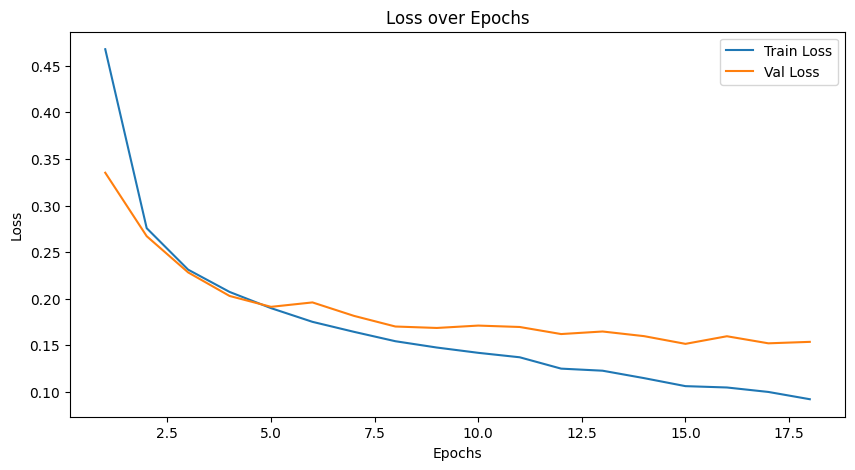

In [18]:
# Loss Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_hist, label='Train Loss')
plt.plot(epochs, val_loss_hist, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

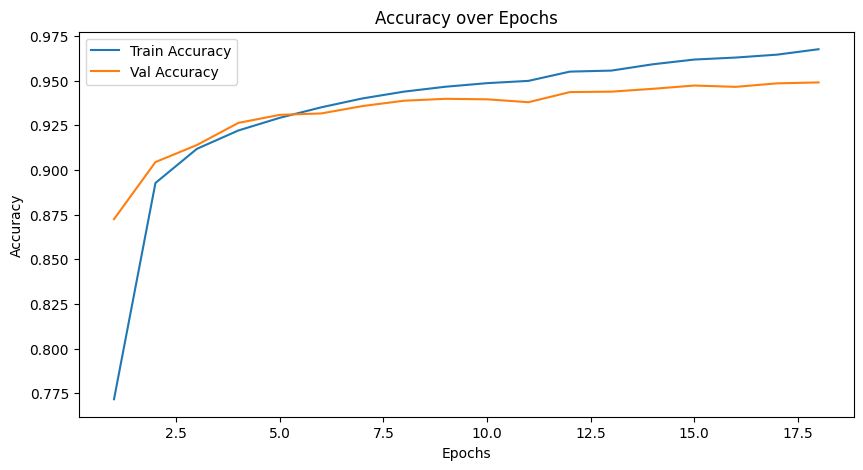

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_hist, label='Train Accuracy')
plt.plot(epochs, val_acc_hist, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

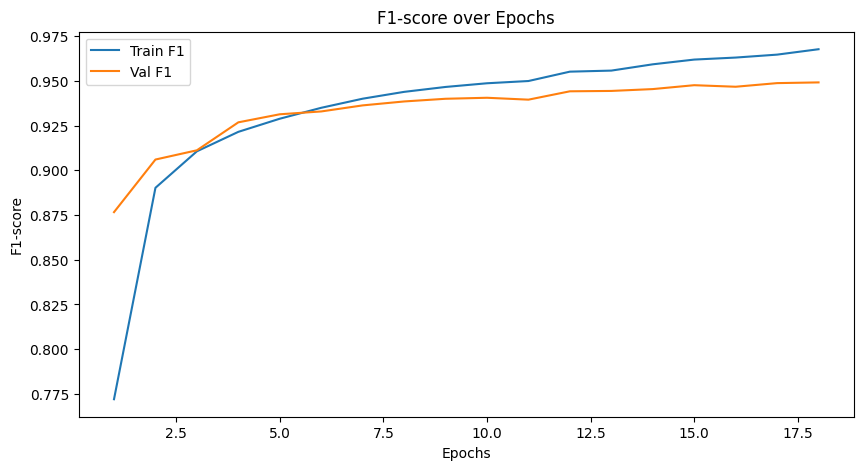

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_f1_hist, label='Train F1')
plt.plot(epochs, val_f1_hist, label='Val F1')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.title('F1-score over Epochs')
plt.legend()
plt.show()

In [51]:
def predict_tweet(tweet, model_path, vocab, tokenizer, max_length=512):
    """
    Predict whether a given tweet is related to suicide or not.

    Args:
        tweet (str): The input tweet text.
        model_path (str): Path to the trained model state dictionary.
        vocab (Vocab): Vocabulary object for token-to-index mapping.
        tokenizer (callable): Tokenizer function.
        max_length (int): Maximum sequence length for padding/truncation.

    Returns:
        str: 'suicide' or 'non-suicide'.
    """
    # Load the trained model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Define the model architecture (matching the trained model)
    vocab_size = len(vocab)
    embed_dim = 256  # Updated to match checkpoint
    hidden_dim = 128  # Match the hidden dimension from training
    num_classes = 2  # Binary classification
    model = TextClassificationModel(vocab_size, embed_dim, hidden_dim, num_classes)

    # Load the state dictionary
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Preprocess the tweet
    tweet = tweet.lower()
    tweet = re.sub(r"http\S+|www.\S+", "", tweet)  # Remove URLs
    tweet = re.sub(r"@\w+", "@user", tweet)  # Standardize mentions
    tweet = re.sub(r"[^\w\s]", "", tweet)  # Remove special characters
    # Tokenize and convert to indices
    tokens = tokenizer(tweet)
    indices = [vocab[token] for token in tokens]

    # Padding/truncation
    if len(indices) < max_length:
        indices = indices + [vocab['<pad>']] * (max_length - len(indices))
    else:
        indices = indices[:max_length]

    # Convert to tensor and make prediction
    input_tensor = torch.tensor([indices], dtype=torch.long).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        prediction = torch.argmax(output, dim=1).item()
        probabilities = torch.nn.functional.softmax(output, dim=1)
        confidence_rate = probabilities[0,prediction].item()

    return tweet, confidence_rate, 'suicide' if prediction == 1 else 'non-suicide'


In [52]:
test_predict_file = '/kaggle/input/test-data/test_demo.txt'
test_result_file = '/kaggle/working/test_demo_result.csv'
with open(test_predict_file,'r') as f:
    tweets = f.readlines()
data = []
tokenizer = get_tokenizer("basic_english")

for i, tweet in enumerate(tweets):
    clean_text, confidence_rate, prediction = predict_tweet(tweet, 'best_model.pt', vocab, tokenizer)
    data.append({
        "Tweet": tweet.strip(),
        "Clean Tweet": clean_text,
        "Prediction": prediction,
        "Confidence rate": confidence_rate,
    })
    df = pd.DataFrame(data)
    clear_output(wait=True)
    display(df)

df.to_csv(test_result_file, index=False)

,Tweet,Clean Tweet,Prediction,Confidence rate
0,making some lunch,making some lunch\n,non-suicide,0.989556
1,@Alexia You want his money.,user you want his money\n,non-suicide,0.971983
2,@dizzyhrvy that crap took me forever to put to...,user that crap took me forever to put together...,suicide,0.970656
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,user kiwitweets hey jer since when did you sta...,non-suicide,0.805527
4,Trying out &quot;Delicious Library 2&quot; wit...,trying out quotdelicious library 2quot with mi...,non-suicide,0.600083
5,"@ValenValdez Oh, that's good to hear. But is i...",user oh thats good to hear but is it over alre...,non-suicide,0.997483
6,@mcm180 u've got a list for fellow #hotties? Y...,user uve got a list for fellow hotties you gon...,non-suicide,0.996431
7,@jakepaul @jamescharles @LoganPaul Just becaus...,user user user just because shane made a serie...,non-suicide,0.860599
8,time for some warsaw beer garden chilling,time for some warsaw beer garden chilling\n,non-suicide,0.901907
9,I hate my life lmao I hope I die soon or sumn ...,i hate my life lmao i hope i die soon or sumn ...,suicide,0.585209


In [55]:
test_tweets = [
    "Feeling so down today. Can't shake this overwhelming sadness.",
    "Life feels so meaningless right now. I just want the pain to stop.",
    "Had a rough day, but tomorrow is a new beginning. Staying hopeful.",
    "I'm so tired of pretending everything is okay when it's not.",
    "Thankful for friends who always remind me I’m not alone.",
    "Sometimes it feels like nobody understands what I’m going through.",
    "This world would be better off without me in it.",
    "I don’t know how much longer I can keep fighting these feelings.",
    "Spending time outdoors helped me feel a little more alive today.",
    "I’ve been crying non-stop for hours. I just feel so hopeless.",
    "Reached out to a friend for support, and they truly listened. Grateful.",
    "The weight of everything is just too much to handle.",
    "Grateful for the little joys in life, like a warm cup of coffee.",
    "I’m scared of my own thoughts and the darkness in my mind.",
    "Tried journaling today to organize my thoughts. It felt freeing.",
    "Hoping tomorrow brings a little more light into my life.",
    "Feeling like a burden to everyone around me. I just want to disappear.",
    "Shared my struggles with someone I trust, and it helped a bit.",
    "Life is full of ups and downs, and today is definitely a down.",
    "It’s hard, but I’m trying to find reasons to keep going.",
    "I hate my life lmao I hope I die soon or sumn I'm too tired of everything",
    "My life is a beautiful journey and I feel so thankful"
]
for tweet in test_tweets:
    clean_text, confidence_rate, prediction = predict_tweet(tweet, 'best_model.pt', vocab, tokenizer)
    print(f"Tweet: {tweet}\nPrediction: {prediction} tweet\nConfidence rate: {confidence_rate:.4f}")
    print()

Tweet: Feeling so down today. Can't shake this overwhelming sadness.
Prediction: suicide tweet
Confidence rate: 0.8636

Tweet: Life feels so meaningless right now. I just want the pain to stop.
Prediction: suicide tweet
Confidence rate: 0.8801

Tweet: Had a rough day, but tomorrow is a new beginning. Staying hopeful.
Prediction: suicide tweet
Confidence rate: 0.5132

Tweet: I'm so tired of pretending everything is okay when it's not.
Prediction: non-suicide tweet
Confidence rate: 0.7299

Tweet: Thankful for friends who always remind me I’m not alone.
Prediction: non-suicide tweet
Confidence rate: 0.9207

Tweet: Sometimes it feels like nobody understands what I’m going through.
Prediction: suicide tweet
Confidence rate: 0.6266

Tweet: This world would be better off without me in it.
Prediction: suicide tweet
Confidence rate: 0.8457

Tweet: I don’t know how much longer I can keep fighting these feelings.
Prediction: suicide tweet
Confidence rate: 0.9608

Tweet: Spending time outdoors hel